<a href="https://colab.research.google.com/github/matthewshawnkehoe/Machine-Learning-in-Python/blob/main/Chapter_13/chapter13_best_practices_for_the_real_world.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it contains text, runnable code blocks, section titles, and a bunch of edits made by Matthew Kehoe.

This notebook was generated for TensorFlow 2.6.

# Best practices for the real world

You've come far since the beginning of this book. You can now train image classification models, image segmentation models, models for classification or regression on vector data, timeseries forecasting models, text-classification models, sequence-to-sequence models, and even generative models for text and images. You've got all
the bases covered.

However,  your  models  so  far  have  all  been  trained  at  a   <font color='blue'>small  scale</font>—on  small datasets,  with  a  single  GPU—and  they  generally  haven't  reached  the  best  achievable performance on each dataset we looked at. This book is, after all, an introductory book. If you are to go out in the <font color='blue'>real world</font> and achieve <font color='blue'>state-of-the-art results</font> on brand new problems, there's still a bit of a chasm that you'll need to cross.
  
This  penultimate  chapter  is  about  bridging  that  gap  and  giving  you  the  best practices  you'll  need  as  you  go  from <font color='blue'>machine  learning  student</font>  to  fully fledged <font color='blue'>machine learning engineer</font>. We'll review essential techniques for systematically improving  model  performance:  <font color='blue'>hyperparameter  tuning</font>  and <font color='blue'>model  ensembling</font>.  Then we'll look at how you can speed up and scale up model training, with <font color='blue'>multi-GPU</font> and <font color='blue'>TPU</font> training, mixed precision, and leveraging remote computing resources in the cloud.

## Getting the most out of your models

Blindly  trying  out  different  architecture  configurations  works  well  enough  if  you just need something that works okay. In this section, we'll go beyond "works okay" to <font color='blue'>works  great  and  wins  machine  learning  competitions</font> via  a  set  of  must-know techniques for building state-of-the-art deep learning models.

### Hyperparameter optimization

When  building  a  deep  learning  model,  you  have  to  make  many  seemingly  arbitrary decisions: How many layers should you stack? How many units or filters should go in each layer? Should you use `relu` as activation, or a different function? Should you use `BatchNormalization` after a given layer? How much dropout should you use? And so on. These <font color='blue'>architecture-level parameters</font> are called `hyperparameters` to distinguish them from the `parameters` of a model, which are <font color='blue'>trained via backpropagation</font>.

In practice, experienced machine learning engineers and researchers <font color='blue'>build intuition  over  time</font>  as  to  what  works  and  what  doesn't  when  it  comes  to these  choices— they develop hyperparameter-tuning skills. But <font color='blue'>there are no formal rules</font>. If you want to get to the very limit of what can be achieved on a given task, you can't be content with such arbitrary choices. Your <font color='blue'>initial decisions are almost always suboptimal</font>, even if you have very good intuition. You can refine your choices by tweaking them by hand and  retraining  the  model  repeatedly—that's  what  machine  learning  engineers  and researchers spend most of their time doing. But it shouldn't be your job as a human to fiddle with hyperparameters all day—that is better left to a machine.

Thus you need to explore the space of possible decisions automatically, systematically, in a principled way. You need to <font color='blue'>search the architecture space</font> and find the best-performing architectures <font color='blue'>empirically</font>. That's what the field of <font color='blue'>automatic hyperparameter optimization</font> is about: it's an entire field of research, and an important one.

The process of optimizing hyperparameters typically looks like this:

1. Choose a set of hyperparameters (automatically).
2. Build the corresponding model.
3. Fit it to your training data, and measure performance on the validation data.
4. Choose the next set of hyperparameters to try (automatically).
5. Repeat.
6. Eventually, measure performance on your test data.

The key to this process is the algorithm that analyzes the relationship between <font color='blue'>validation  performance</font>  and  various  <font color='blue'>hyperparameter  values</font>  to  choose  the  next  set  of hyperparameters to evaluate. Many different techniques are possible: Bayesian optimization, genetic algorithms, simple random search, and so on.

Training the weights of a model is relatively easy: you compute a <font color='blue'>loss function</font> on a <font color='blue'>mini-batch</font>  of  data  and  then  use  <font color='blue'>backpropagation</font>  to  move  the  weights  in  the  right direction. Updating hyperparameters, on the other hand, presents unique challenges.

Consider these points:

* The  <font color='blue'>hyperparameter  space</font> is  typically  made  up  of  <font color='blue'>discrete  decisions</font>  and thus isn't continuous or differentiable. Hence, you typically <font color='blue'>can't do gradient descent</font> in hyperparameter space. Instead, you must rely on <font color='blue'>gradient-free optimization techniques</font>, which naturally are far less efficient than gradient descent.
* Computing  the  feedback  signal  of  this  optimization  process  (does  this  set  of hyperparameters lead to a high-performing model on this task?) can be <font color='blue'>extremely expensive</font>: it requires creating and training a new model from scratch on your dataset.
* The feedback signal may be <font color='blue'>noisy</font>: if a training run performs 0.2% better, is that because of a better model configuration, or because you got lucky with the initial weight values?

Thankfully, there's  a  tool  that  makes  hyperparameter  tuning  simpler:  <font color='blue'>KerasTuner</font>. Let's check it out.

#### Using KerasTuner

Let's start by installing KerasTuner:

In [ ]:
!pip install keras-tuner -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.0 MB/s eta 0:00:00


KerasTuner  lets  you  replace  <font color='blue'>hard-coded  hyperparameter  values</font>,  such  as  `units=32`, with a <font color='blue'>range of possible choices</font>, such as `Int(name="units", min_value=16,max_value=64, step=16)`. This <font color='blue'>set of choices</font> in a given model is called the <font color='blue'>search space</font> of the hyperparameter tuning process.

To specify a search space, define a model-building function (see the listing below). It  takes  an  <font color='blue'>hp  argument</font>,  from  which  you  can  sample  hyperparameter  ranges,  and  it returns a compiled Keras model.

**A KerasTuner model-building function**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def build_model(hp):
    units = hp.Int(name="units", min_value=16, max_value=64, step=16)           # Sample hyperparameter values from the hp object. After sampling, these values
    model = keras.Sequential([                                                  # (such as the "units" variable here) are just regular Python constants.
        layers.Dense(units, activation="relu"),
        layers.Dense(10, activation="softmax")
    ])
    optimizer = hp.Choice(name="optimizer", values=["rmsprop", "adam"])         # Different kinds of hyperparameters are available: Int, Float, Boolean, Choice.
    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"])
    return model                                                                # The function returns a compiled model.

If you want to adopt a more <font color='blue'>modular</font> and configurable <font color='blue'>approach</font> to model-building,
you can also subclass the `HyperModel` class and define a `build` method, as follows.

**A KerasTuner `HyperModel`**

In [ ]:
import keras_tuner as kt

class SimpleMLP(kt.HyperModel):
    def __init__(self, num_classes):                                            # Thanks to the object-oriented approach, we can configure model constants as
        self.num_classes = num_classes                                          # constructor arguments (instead of hardcoding them in the model-building function).

    def build(self, hp):                                                        # The build() method is identical to our prior  build_model() standalone function.
        units = hp.Int(name="units", min_value=16, max_value=64, step=16)
        model = keras.Sequential([
            layers.Dense(units, activation="relu"),
            layers.Dense(self.num_classes, activation="softmax")
        ])
        optimizer = hp.Choice(name="optimizer", values=["rmsprop", "adam"])
        model.compile(
            optimizer=optimizer,
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"])
        return model

hypermodel = SimpleMLP(num_classes=10)

The next step is to define a <font color='blue'>tuner</font>. Schematically, you can think of a tuner as a <font color='blue'>for loop</font> that will repeatedly

* Pick a set of hyperparameter values
* Call the model-building function with these values to create a model
* Train the model and record its metrics

KerasTuner has several built-in tuners available—`RandomSearch`, `BayesianOptimization`, and `Hyperband`. Let's try `BayesianOptimization`, a tuner that attempts to make smart <font color='blue'>predictions</font>  for  which  <font color='blue'>new hyperparameter  values</font>  are  likely  to  perform  best given the outcomes of previous choices:

In [ ]:
tuner = kt.BayesianOptimization(
    build_model,                                                                # Specify the model-building function (or hyper-model instance).
    objective="val_accuracy",                                                   # Specify the metric that the tuner will seek to optimize. Always specify validation metrics,
                                                                                # since the goal of the search process is to find models that generalize!
    max_trials=100,                                                             # Maximum number of different model configurations (“trials”) to try before ending the search.
    executions_per_trial=2,                                                     # To reduce metrics variance, you can train the same model multiple times and average the results.
                                                                                # executions_per_trial is how many training rounds (executions) to run for each model configuration (trial).
    directory="mnist_kt_test",                                                  # Where to store the search logs.
    overwrite=True,                                                             # Whether to overwrite data in directory to start a new search. Set this to True if you’ve modified
                                                                                # the model-building function, or to False to resume a previously started search with the same
                                                                                # model-building function.
)

You can display an overview of the search space via `search_space_summary()`:

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'rmsprop', 'conditions': [], 'values': ['rmsprop', 'adam'], 'ordered': False}


### Objective maximization and minimization
For built-in metrics (like accuracy, in our case), the *direction* of the metric (<font color='blue'>accuracy</font> should  be  <font color='blue'>maximized</font>,  but  a  <font color='blue'>loss</font>  should  be <font color='blue'>minimized</font>)  is  inferred  by  KerasTuner. However, for a custom metric, you should specify it yourself, like this:

In [ ]:
# Pseudocode
objective = kt.Objective(
    name="val_accuracy",                                                        # The metric’s name, as found in epoch logs
    direction="max")                                                            # The metric’s desired direction: "min" or "max"
tuner = kt.BayesianOptimization(
    build_model,
    objective=objective,
    ...
)

SyntaxError: positional argument follows keyword argument (<ipython-input-6-87b81cd4278e>, line 9)

Finally, let's launch the search. Don't forget to <font color='blue'>pass validation data</font>, and make sure <font color='blue'>not to use your test set as validation data</font>—otherwise you'd quickly start overfitting to your test data, and you wouldn't be able to trust your test metrics anymore:

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape((-1, 28 * 28)).astype("float32") / 255
x_test = x_test.reshape((-1, 28 * 28)).astype("float32") / 255
x_train_full = x_train[:]                                                       # Reserve for later
y_train_full = y_train[:]                                                       # Reserve for later
num_val_samples = 10000
x_train, x_val = x_train[:-num_val_samples], x_train[-num_val_samples:]         # Set aside as a validation set
y_train, y_val = y_train[:-num_val_samples], y_train[-num_val_samples:]         # Set aside as a validation set
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5),              # Use an EarlyStopping callback to stop training when you start overfitting
]
tuner.search(                                                                   # This takes the same arguments as fit() (it simply passes them down to fit() for each new model).
    x_train, y_train,
    batch_size=128,
    epochs=80,                                                                 # Use a large number of epochs (you don’t know in advance how many epochs each model will need)
    validation_data=(x_val, y_val),
    callbacks=callbacks,
    verbose=2,
)

Trial 100 Complete [00h 01m 00s]
val_accuracy: 0.9754499793052673

Best val_accuracy So Far: 0.9769999980926514
Total elapsed time: 01h 56m 13s


The  preceding  example  will  run  in  <font color='blue'>just  a  few  minutes</font>,  since  we're  only  looking  at  a few  possible  choices  and  we're  training  on  MNIST.  However,  with  a  typical  search space  and  dataset,  you'll  often  find  yourself  letting  the  <font color='blue'>hyperparameter  search  run overnight  or  even  over  several  days</font>.  If  your  search  process  crashes,  you  can  always restart  it—just  specify `overwrite=False`  in  the  tuner  so  that  it  can  resume  from the trial logs stored on disk.

Once  the  search  is  complete,  you  can  <font color='blue'>query  the  best  hyperparameter  configurations</font>, which you can use to create high-performing models that you can then retrain.

**Querying the best hyperparameter configurations**

In [ ]:
top_n = 4
best_hps = tuner.get_best_hyperparameters(top_n)                                # Returns a list of HyperParameter objects, which you can pass to the model-building function

Usually, when <font color='blue'>retraining</font> these models, you may want to include the <font color='blue'>validation data</font> as <font color='blue'>part  of  the  training  data</font>,  since  you  won't  be  making  any  further  hyperparameter changes,  and  thus  you  will  no  longer  be   evaluating  performance  on  the  validation data.  In  our  example, we'd  train  these  final  models  on  the  totality  of  the  original
MNIST training data, without reserving a validation set.

Before we can train on the full training data, though, there's one last parameter we need to settle: the <font color='blue'>optimal number of epochs to train for</font>. Typically, you'll want to train the  new  models  for  longer  than  you  did  during  the  search:  using  an  aggressive `patience` value in the `EarlyStopping` callback saves time during the search, but it may lead to under-fit models. Just <font color='blue'>use the validation set</font> to find the <font color='blue'>best epoch</font>:

In [ ]:
def get_best_epoch(hp):
    model = build_model(hp)
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="val_loss", mode="min", patience=10)                        # Note the high patience value
    ]
    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=100,
        batch_size=128,
        callbacks=callbacks)
    val_loss_per_epoch = history.history["val_loss"]
    best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
    print(f"Best epoch: {best_epoch}")
    return best_epoch

Finally, <font color='blue'>train  on  the  full  dataset</font>  for  just  a  bit  longer  than  this  epoch  count, since you're training on more data; 20% more in this case:

In [ ]:
def get_best_trained_model(hp):
    best_epoch = get_best_epoch(hp)
    model = build_model(hp)
    model.fit(
        x_train_full, y_train_full,
        batch_size=128, epochs=int(best_epoch * 1.2))
    return model

best_models = []
for hp in best_hps:
    model = get_best_trained_model(hp)
    model.evaluate(x_test, y_test)
    best_models.append(model)

Epoch 1/100
391/391 [==============================] - 2s 4ms/step - loss: 0.4201 - accuracy: 0.8858 - val_loss: 0.2350 - val_accuracy: 0.9354
Epoch 2/100
391/391 [==============================] - 1s 4ms/step - loss: 0.2201 - accuracy: 0.9372 - val_loss: 0.1800 - val_accuracy: 0.9528
Epoch 3/100
391/391 [==============================] - 1s 3ms/step - loss: 0.1701 - accuracy: 0.9513 - val_loss: 0.1568 - val_accuracy: 0.9562
Epoch 4/100
391/391 [==============================] - 1s 3ms/step - loss: 0.1402 - accuracy: 0.9596 - val_loss: 0.1350 - val_accuracy: 0.9629
Epoch 5/100
391/391 [==============================] - 1s 4ms/step - loss: 0.1198 - accuracy: 0.9649 - val_loss: 0.1226 - val_accuracy: 0.9654
Epoch 6/100
391/391 [==============================] - 1s 3ms/step - loss: 0.1032 - accuracy: 0.9699 - val_loss: 0.1158 - val_accuracy: 0.9663
Epoch 7/100
391/391 [==============================] - 2s 4ms/step - loss: 0.0920 - accuracy: 0.9739 - val_loss: 0.1092 - val_accuracy: 0.9681

Note that if you're not worried about slightly underperforming, there's a shortcut you can take: just <font color='blue'>use the tuner</font> to <font color='blue'>reload the top-performing models</font> with the <font color='blue'>best weights</font> saved during the hyperparameter search, without retraining new models from scratch:

In [ ]:
best_models = tuner.get_best_models(top_n)

# Create a checkpoint with write()
ckpt = tf.train.Checkpoint(v=tf.Variable(1.))
path = ckpt.write('/tmp/my_checkpoint')

checkpoint = tf.train.Checkpoint(model)
checkpoint.restore(path).expect_partial()

for model in best_models:
  print(model.evaluate(x_test, y_test))

313/313 [==============================] - 5s 14ms/step - loss: 0.0830 - accuracy: 0.9772
[0.08303790539503098, 0.9771999716758728]
313/313 [==============================] - 4s 13ms/step - loss: 0.0841 - accuracy: 0.9768
[0.0840606540441513, 0.9768000245094299]
313/313 [==============================] - 5s 16ms/step - loss: 0.0884 - accuracy: 0.9751
[0.08838500827550888, 0.9750999808311462]
313/313 [==============================] - 4s 13ms/step - loss: 0.0879 - accuracy: 0.9738
[0.08788144588470459, 0.973800003528595]


**Remark:** One  important  issue  to  think  about  when  doing  automatic  hyperparameter  optimization  at  scale  is  <font color='blue'>validation-set  overfitting</font>.  Because  you're updating hyperparameters based on a signal that is computed using your validation data, you're effectively <font color='blue'>training them on the validation data</font>, and thus they will <font color='blue'>quickly overfit</font> to the validation data. Always keep this in mind.

#### The art of crafting the right search space

Overall, <font color='blue'>hyperparameter  optimization</font> is  a  powerful  technique  that  is  an  absolute requirement for getting to state-of-the-art models on any task or to <font color='blue'>win machine learning competitions</font>. Think about it: once upon a time, people handcrafted the features that  went  into  shallow  machine  learning  models.  That  was  very  much  suboptimal. Now, deep learning <font color='blue'>automates</font> the task of <font color='blue'>hierarchical feature engineering</font>—features are learned using a feedback signal, not hand-tuned, and that's the way it should be. In the same way, you shouldn't handcraft your model architectures; you should optimize them in a principled way.

However, doing hyperparameter tuning is <font color='blue'>not a replacement</font> for being familiar
with <font color='blue'>model architecture best practices</font>. <font color='blue'>Search spaces grow combinatorially</font> with the number of choices, so it would be far too expensive to turn everything into a hyperparameter  and  let  the  tuner  sort  it  out.  You  need  to  be  smart  about  designing  the right  search  space. Hyperparameter  tuning is  automation,  not  magic:  you  use it to automate  experiments  that  you  would  otherwise  have  run  by  hand,  but  you  still need  to  handpick  experiment  configurations  that  have  the  potential  to  yield  good metrics.

The  good  news  is  that  by  <font color='blue'>leveraging  hyperparameter  tuning</font>,  the  configuration decisions you have to make graduate from <font color='blue'>micro-decisions</font> (what number of units do I pick for this layer?) to <font color='blue'>higher-level architecture decisions</font> (should I use residual connections throughout this model?). And while micro-decisions are specific to a certain model and a certain dataset, higher-level decisions generalize better across different tasks  and  datasets.  For  instance,  pretty  much  every  <font color='blue'>image  classification  problem</font> can be solved via the <font color='blue'>same sort of search-space template</font>.

Following this logic, <font color='blue'>KerasTuner</font> attempts to <font color='blue'>provide premade search spaces</font> that are relevant to <font color='blue'>broad categories of problems</font>, such as image classification. Just add data, run the search, and get a pretty good model. You can try the hypermodels `kt.applications.HyperXception` and `kt.applications.HyperResNet`,  which are effectively tunable versions of Keras Applications models.

#### The future of hyperparameter tuning: automated machine learning

Currently, most of your job as a deep learning engineer consists of <font color='blue'>munging data with Python scripts</font> and then <font color='blue'>tuning the architecture and hyperparameters</font> of a deep network at length to get a working model, or even to get a state-of-the-art model, if you are  that  ambitious.  Needless  to  say,  that  isn't  an  optimal  setup.  But  automation  can help, and it won't stop merely at hyperparameter tuning.

Searching over a set of possible learning rates or possible layer sizes is just the first step. We can also be far <font color='blue'>more ambitious</font> and attempt to <font color='blue'>generate the model architecture itself from scratch</font>, with as few constraints as possible, such as <font color='blue'>via reinforcement learning</font> or <font color='blue'>genetic algorithms</font>. In the future, <font color='blue'>entire end-to-end machine learning pipelines</font> will be <font color='blue'>automatically generated</font>, rather than be handcrafted by engineer-artisans. This is called automated machine learning, or <font color='blue'>AutoML</font>. You can already leverage libraries like  AutoKeras  (https://github.com/keras-team/autokeras) to solve basic machine learning problems with very little involvement on your part.

Today, AutoML  is  still in its  early  days,  and  it  doesn't  scale to  large  problems.  But when AutoML becomes mature enough for widespread adoption, the jobs of machine learning engineers won't disappear—rather, engineers will move up the value-creation chain. They will begin to put much more effort into data curation, crafting complex loss functions  that  truly  reflect  business  goals,  as  well  as  understanding  how  their  models
impact the digital ecosystems in which they're deployed (such as the users who consume the model's predictions and generate the model's training data). These are problems that only the largest companies can afford to consider at present.

Always look at the big picture, focus on understanding the fundamentals, and keep in mind that the <font color='blue'>highly specialized tedium will eventually be automated away</font>. See it as a gift—greater productivity for your workflows—and not as a threat to your own relevance. It shouldn't be your job to tune knobs endlessly.

### Model ensembling

Another powerful technique for obtaining the best possible results on a task is <font color='blue'>model ensembling</font>. Ensembling consists of <font color='blue'>pooling together</font> the predictions of a <font color='blue'>set of different  models</font>  to  produce <font color='blue'>better  predictions</font>.  If  you  look  at  machine  learning  competitions, in particular on Kaggle, you'll see that the winners use very <font color='blue'>large ensembles of models</font> that inevitably beat any single model, no matter how good.

<font color='blue'>Ensembling</font>  relies  on  the  assumption  that  <font color='blue'>different  well-performing  models</font> trained independently are likely to be good for <font color='blue'>different reasons</font>: each model looks at slightly different aspects of the data to make its predictions, getting part of the "truth" but not all of it. You may be familiar with the ancient parable of the blind men and the elephant: a group of blind men come across an elephant for the first time and try to understand what the elephant is by touching it. Each man touches a different part of the elephant's body—just one part, such as the trunk or a leg. Then the men describe
to each other what an elephant is: "It's like a snake," "Like a pillar or a tree," and so on. The blind men are essentially machine learning models trying to understand the manifold  of  the  training  data,  each  from  their  own  perspective,  using  their  own assumptions (provided by the unique architecture of the model and the unique random weight initialization). Each of them gets <font color='blue'>part of the truth</font> of the data, but <font color='blue'>not the whole truth</font>. By <font color='blue'>pooling</font> their perspectives together, you can get a <font color='blue'>far more accurate description of the data</font>. The elephant is a combination of parts: not any single blind man gets it quite right, but, interviewed together, they can tell a fairly accurate story.

Let's use classification as an example. The easiest way to pool the predictions of a set of classifiers (to *ensemble the classifiers*) is to <font color='blue'>average their predictions</font> at inference time:

In [ ]:
# Psuedocode
preds_a = model_a.predict(x_val)                                                # Use four different models to compute initial predictions.
preds_b = model_b.predict(x_val)
preds_c = model_c.predict(x_val)
preds_d = model_d.predict(x_val)
final_preds = 0.25 * (preds_a + preds_b + preds_c + preds_d)                    # This new prediction array should be more accurate than any of the initial ones.

However, this will <font color='blue'>only work</font> if the <font color='blue'>classifiers</font> are <font color='blue'>more or less equally good</font>. If one of them is significantly worse than the others, the final predictions may not be as good as the best classifier of the group.

A  smarter  way  to  ensemble  classifiers  is  to  do  a  <font color='blue'>weighted  average</font>,  where  the weights are learned on the validation data—typically, the better classifiers are given a higher weight, and the worse classifiers are given a lower weight. To search for a good set of ensembling weights, you can use <font color='blue'>random search</font> or a simple <font color='blue'>optimization algorithm</font>, such as the <font color='blue'>[Nelder-Mead algorithm](https://en.wikipedia.org/wiki/Nelder%E2%80%93Mead_method)</font>:

In [ ]:
# Psuedocode
preds_a = model_a.predict(x_val)                                                # Use four different models to compute initial predictions.
preds_b = model_b.predict(x_val)
preds_c = model_c.predict(x_val)
preds_d = model_d.predict(x_val)
final_preds = 0.5 * preds_a + 0.25 * preds_b + 0.1 * preds_c + 0.15 * preds_d   # These weights (0.5, 0.25, 0.1, 0.15) are assumed to be learned empirically.

There are many possible variants: you can do an <font color='blue'>average</font> of an <font color='blue'>exponential of the predictions</font>, for  instance.  In  general,  a  <font color='blue'>simple  weighted  average</font>  with  weights  optimized on the validation data provides a very <font color='blue'>strong baseline</font>.

The key to making ensembling work is the <font color='blue'>diversity</font> of the <font color='blue'>set of classifiers</font>. Diversity is strength. If all the blind men only touched the elephant's trunk, they would agree that elephants are like snakes, and they would forever stay ignorant of the truth of the elephant. Diversity is what makes ensembling work. In machine learning terms, if all of your models are <font color='blue'>biased in the same way</font>, your <font color='blue'>ensemble</font> will <font color='blue'>retain this same bias</font>. If your models are <font color='blue'>biased in different ways</font>, the <font color='blue'>biases</font> will <font color='blue'>cancel each other out</font>, and the ensemble will be more robust and more accurate.

For this reason, you should ensemble models that are <font color='blue'>as good as possible</font> while being <font color='blue'>as different as possible</font>. This typically means using very <font color='blue'>different architectures</font> or even <font color='blue'>different brands</font> of machine learning approaches. One thing that is largely <font color='blue'>not worth doing</font> is ensembling the <font color='blue'>same network trained several times independently</font>, from different random initializations. If the only difference between your models is their random initialization and the order in which they were exposed to the training data, then your ensemble will be low-diversity and will provide only a tiny improvement over any single model.

One  thing  I  have  found  to  work  well  in  practice—but  that  doesn't  generalize  to every problem domain—is using an <font color='blue'>ensemble of tree-based methods</font> (such as random forests  or  gradient-boosted  trees)  and  deep  neural  networks.  In  2014,  Andrey  Kolev and  I  took  fourth  place  in  the  Higgs  Boson  decay  detection  challenge  on  Kaggle (www.kaggle.com/c/higgs-boson) using an ensemble of various tree models and deep neural  networks.  Remarkably,  one  of the  models  in the  ensemble  originated  from  a different method than the others (it was a regularized greedy forest), and it had a significantly worse score than the others. Unsurprisingly, it was assigned a small weight in the ensemble. But to our surprise, it turned out to improve the overall ensemble by a large factor, because it was so different from every other model: it provided information that the other models didn't have access to. That's precisely the <font color='blue'>point of ensembling</font>. It's not so much about how good your best model is; it's about the <font color='blue'>diversity of your set of candidate models</font>.

## Scaling-up model training

Recall the <font color='blue'>loop of progress</font> concept we introduced in chapter 7: the quality of your ideas is a function of how many refinement cycles they've been through (see figure below). And the <font color='blue'>speed</font> at which you can iterate on an idea is a function of how fast you can set up an experiment, how fast you can run that experiment, and finally, how well you can analyze the resulting data.

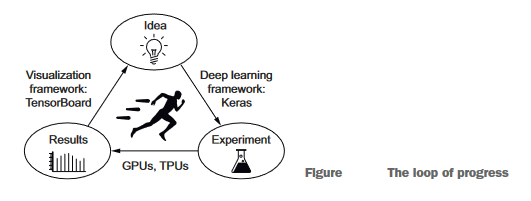

As you develop your expertise with the Keras API, <font color='blue'>how fast you can code</font> up your deep learning experiments will <font color='blue'>cease to be the bottleneck</font> of this progress cycle. The next bottleneck will become the <font color='blue'>speed at which you can train your models</font>. Fast training infrastructure means that you can get your results back in 10–15 minutes, and hence, that you can go through dozens of iterations every day. <font color='blue'>Faster training</font> directly improves the <font color='blue'>quality</font> of your deep learning solutions.

In this section, you'll learn about three ways you can train your models faster:

* Mixed-precision training, which you can use even with a single GPU
* Training on multiple GPUs
* Training on TPUs

Let's go.

### Speeding up training on GPU with mixed precision

What if I told you there's a <font color='blue'>simple technique</font> you can use to speed up the training of <font color='blue'>almost any model by up to 3X</font>, basically for <font color='blue'>free</font>? It seems too good to but true, and yet, such a trick does exist. That's <font color='blue'>mixed-precision training</font>. To understand how it works, we first need to take a look at the notion of <font color='blue'>precision</font> in computer science.

#### Understanding floating-point precision

Precision is to numbers what resolution is to images. Because computers can only process ones and zeros, <font color='blue'>any number</font> seen by a computer has to be <font color='blue'>encoded</font> as a <font color='blue'>binary string</font>. For instance, you may be familiar with `uint8` integers, which are integers encoded on eight bits: `00000000` represents `0` in `uint8`, and `11111111` represents `255`. To represent integers beyond `255`, you'd need to <font color='blue'>add more bits</font>—eight isn't enough. <font color='blue'>Most integers</font> are stored on `32` bits, with which you can represent signed integers ranging from `-2147483648` to `2147483647`.

Floating-point numbers are the same. In mathematics, <font color='blue'>real numbers</font> form a <font color='blue'>continuous axis</font>: there's an <font color='blue'>infinite number</font> of <font color='blue'>points</font> in between any <font color='blue'>two numbers</font>. You can always zoom in on the axis of reals. In <font color='blue'>computer science</font>, this isn't true: there's a <font color='blue'>finite number</font> of intermediate points between <font color='blue'>3 and 4</font>, for instance. How many? Well, it depends on the <font color='blue'>precision</font> you're working with—the <font color='blue'>number of bits</font> you're using to <font color='blue'>store a number</font>. You can only zoom up to a certain resolution.

There are three of levels of precision you'd typically use:
* Half precision, or `float16`, where numbers are stored on 16 bits
* Single precision, or `float32`, where numbers are stored on 32 bits
* Double precision, or `float64`, where numbers are stored on 64 bits

#### A note on floating-point encoding

A <font color='blue'>counterintuitive fact</font> about <font color='blue'>floating-point numbers</font> is that representable numbers are <font color='blue'>not uniformly distributed</font>. <font color='blue'>Larger numbers</font> have <font color='blue'>lower precision</font>: there are the same number of representable values between `2^N` and `2^(N + 1)` as there are between `1` and `2`, for any `N`. That's because floating-point numbers are encoded in <font color='blue'>three parts</font>—the <font color='blue'>sign</font>, the <font color='blue'>significant value</font> (called the <font color='blue'>mantissa</font>), and the <font color='blue'>exponent</font>, in the form

$$ \operatorname{sign} \times (2 ^{\operatorname{exponent}- 127}) \times 1.\operatorname{mantissa}$$

For example, here's how you would encode the closest `float32` value approximating $\pi$ :

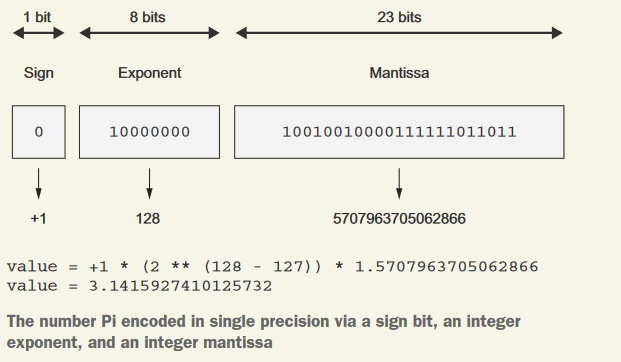

The way to think about the <font color='blue'>resolution of floating-point numbers</font> is in terms of the <font color='blue'>smallest distance</font> between <font color='blue'>two arbitrary numbers</font> that you'll be able to <font color='blue'>safely process</font>. In single precision, that's around `1e-7`. In double precision, that's around `1e-16`. And in half precision, it's only `1e-3`.

Every model you've seen in this book so far used <font color='blue'>single-precision numbers</font>: it stored its state as `float32` weight variables and ran its computations on `float32` inputs. That's <font color='blue'>enough precision</font> to run the <font color='blue'>forward and backwards pass of a model</font> without losing any information—particularly when it comes to small gradient updates (recall that the typical learning rate is `1e-3`, and it's pretty common to see weight updates on the order of `1e-6`).

You could also use `float64`, though that would be <font color='blue'>wasteful—operations</font> like <font color='blue'>matrix multiplication</font> or <font color='blue'>addition</font> are <font color='blue'>much more expensive</font> in <font color='blue'>double precision</font>, so you'd be doing twice as much work for no clear benefits. But you could not do the same with `float16` weights and computation; the <font color='blue'>gradient descent process wouldn't run smoothly</font>, since you couldn't represent small gradient updates of around `1e-5` or `1e-6`.

You can, however, use a <font color='blue'>hybrid approach</font>: that's what mixed precision is about. The idea is to leverage `16`-bit computations in places where precision isn't an issue, and to work with `32`-bit values in other places to maintain numerical stability. Modern <font color='blue'>GPUs</font> and <font color='blue'>TPUs</font> feature <font color='blue'>specialized hardware</font> that can run `16`-bit operations <font color='blue'>much faster and use less memory</font> than equivalent `32`-bits operations. By using these lower-precision operations whenever possible, you can speed up training on those devices by a significant factor. Meanwhile, by maintaining the precision-sensitive parts of the model in single precision, you can get these benefits without meaningfully impacting model quality.

And those benefits are considerable: on <font color='blue'>modern NVIDIA GPUs</font>, <font color='blue'>mixed precision</font> can speed up training by up to `3X`. It's also beneficial when <font color='blue'>training on a TPU</font> (a subject we'll get to in a bit), where it can speed up training by up to `60%`.

#### Beware of dtype defaults
<font color='blue'>Single precision</font> is the <font color='blue'>default</font> floating-point type throughout <font color='blue'>Keras</font> and <font color='blue'>TensorFlow</font>: any tensor or variable you create will be in `float32` unless you specify otherwise. For <font color='blue'>NumPy</font> arrays, however, the default is <font color='blue'>double precision</font> or `float64`!

Converting a default NumPy array to a TensorFlow tensor will result in a `float64` tensor, which may not be what you want:

In [ ]:
import tensorflow as tf
import numpy as np
np_array = np.zeros((2, 2))
tf_tensor = tf.convert_to_tensor(np_array)
tf_tensor.dtype

tf.float64

Remember to be <font color='blue'>explicit</font> about <font color='blue'>data types</font> when converting NumPy arrays:

In [ ]:
np_array = np.zeros((2, 2))
tf_tensor = tf.convert_to_tensor(np_array, dtype="float32")
tf_tensor.dtype

tf.float32

Note that when you call the Keras `fit()` method with NumPy data, it will do this conversion for you.

#### Mixed-precision training in practice

When training on a GPU, you can turn on mixed precision like this:

In [ ]:
from tensorflow import keras
keras.mixed_precision.set_global_policy("mixed_float16")

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


Typically, <font color='blue'>most</font> of the <font color='blue'>forward pass of the model</font> will be done in `float16` (with the exception of numerically unstable operations like softmax), while the <font color='blue'>weights of the model</font> will be stored and updated in `float32`.

Keras layers have a `variable_dtype` and a `compute_dtype` attribute. By default, both of these are set to `float32`. When you turn on <font color='blue'>mixed precision</font>, the `compute_dtype` of most layers switches to `float16`, and those layers will cast their inputs to `float16` and will perform their computations in `float16` (using half-precision copies of the weights). However, since their `variable_dtype` is still `float32`, their weights will be able to receive accurate `float32` updates from the optimizer, as opposed to half-precision updates.

Note that <font color='blue'>some operations</font> may be <font color='blue'>numerically unstable</font> in `float16` (in particular, softmax and crossentropy). If you need to <font color='blue'>opt out of mixed precision</font> for a <font color='blue'>specific layer</font>, just pass the argument `dtype="float32"` to the constructor of this layer.

### Multi-GPU training

While GPUs are getting more powerful every year, deep learning models are getting increasingly larger, requiring ever more computational resources. Training on a <font color='blue'>single GPU</font> puts a <font color='blue'>hard bound</font> on how fast you can move. The solution? You could simply <font color='blue'>add more GPUs</font> and start doing <font color='blue'>multi-GPU distributed training</font>.

There are two ways to distribute computation across multiple devices: <font color='blue'>data parallelism</font> and <font color='blue'>model parallelism</font>.

With data parallelism, a <font color='blue'>single model</font> is <font color='blue'>replicated</font> on <font color='blue'>multiple devices</font> or multiple machines. Each of the model replicas <font color='blue'>processes different batches of data</font>, and then they <font color='blue'>merge</font> their results.

With model parallelism, <font color='blue'>different parts</font> of a single <font color='blue'>model</font> run on <font color='blue'>different devices</font>, processing a <font color='blue'>single batch</font> of <font color='blue'>data together</font> at the same time. This works best with models that have a naturally parallel architecture, such as models that feature multiple branches.

In practice, <font color='blue'>model parallelism</font> is only used for <font color='blue'>models</font> that are <font color='blue'>too large to fit on any single device</font>: it isn't used as a way to speed up training of regular models, but as a way to <font color='blue'>train larger models</font>. We won't cover model parallelism in these pages; instead we'll focus on what you'll be <font color='blue'>using most</font> of the time: <font color='blue'>data parallelism</font>. Let's take a look at how it works.

#### Getting your hands on two or more GPUs

First, you need to <font color='blue'>get access</font> to <font color='blue'>several GPUs</font>. As of now, Google Colab only lets you use a single GPU, so you will need to do one of two things:

* Acquire 2-4 GPUs, mount them on a single machine (it will require a beefy
power supply), and install CUDA drivers, cuDNN, etc. For most people, this
isn't the best option.
* Rent a multi-GPU Virtual Machine (VM) on Google Cloud, Azure, or AWS.
You'll be able to use VM images with preinstalled drivers and software, and
you'll have very little setup overhead. This is <font color='blue'>likely the best option</font> for anyone who isn't training models 24/7.

We won't cover the details of how to spin up multi-GPU cloud VMs, because such instructions would be relatively short-lived, and this information is readily available online.

And if you don't want to deal with the overhead of managing your own VM
instances, you can use TensorFlow Cloud (https://github.com/tensorflow/cloud), a
package that my team and I have recently released—it enables you to start training on multiple GPUs by just adding one line of code at the start of a Colab notebook. If you're looking for a seamless transition from debugging your model in Colab to training it as fast as possible on as many GPUs as you want, check it out.

#### Single-host, multi-device synchronous training

Once you're able to import tensorflow on a machine with multiple GPUs, you're seconds away from training a distributed model. It works like this:

In [ ]:
strategy = tf.distribute.MirroredStrategy()                                     # Create a “distribution strategy” object. MirroredStrategy should be your go-to solution.
print(f"Number of devices: {strategy.num_replicas_in_sync}")
with strategy.scope():                                                          # Use it to open a “strategy scope.”
  model = get_compiled_model()                                                  # Everything that creates variables should be under the strategy scope. In general, this is only model construction and compile().
model.fit(                                                                      # Train the model on all available devices.
  train_dataset,
  epochs=100,
  validation_data=val_dataset,
  callbacks=callbacks)

These few lines implement the most common training setup: *single-host*, *multi-device synchronous training*, also known in TensorFlow as the <font color='blue'>mirrored distribution strategy</font>. <font color='blue'>Single host</font> means that the <font color='blue'>different GPUs</font> considered are <font color='blue'>all on a single machine</font> (as opposed to a cluster of many machines, each with its own GPU, communicating over a network). <font color='blue'>Synchronous training</font> means that the <font color='blue'>state of the per-GPU model replicas stays the same</font> at all times—there are variants of distributed training where this isn't the case.

When you open a <font color='blue'>MirroredStrategy</font> scope and build your model within it, the <font color='blue'>MirroredStrategy object</font> will create one model copy (replica) on each available GPU.

Then, each step of training unfolds in the following way (see figure below):

1. A batch of data (called *global batch*) is drawn from the dataset.
2. It gets split into four different sub-batches (called *local batches*). For instance, if the global batch has `512` samples, each of the four local batches will have `128` samples. Because you want local batches to be large enough to keep the GPU busy, the global batch size typically needs to be very large.
3. Each of the four replicas processes one local batch, independently, on its own device: they run a forward pass, and then a backward pass. Each replica outputs a "weight delta" describing by how much to update each weight variable in the model, given the gradient of the previous weights with respect to the loss of the model on the local batch.
4. The weight deltas originating from local gradients are efficiently merged across the four replicas to obtain a global delta, which is applied to all replicas. Because this is done at the end of every step, the replicas always stay in sync: their weights are always equal.



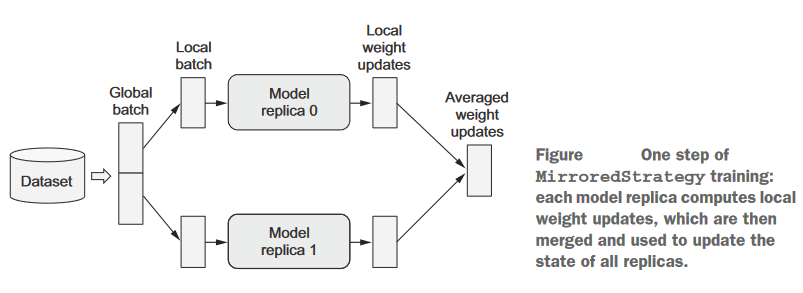

#### `tf.data` performance tips
When doing distributed training, always provide your data as a `tf.data.Dataset`
object to guarantee best performance. (Passing your data as NumPy arrays also
works, since those get converted to Dataset objects by `fit()`). You should also
make sure you leverage <font color='blue'>data prefetching</font>: before passing the dataset to `fit()`, call `dataset.prefetch(buffer_size)`. If you aren't sure what buffer size to pick, try the <font color='blue'>`dataset.prefetch(tf.data.AUTOTUNE)`</font> option, which will pick a buffer size for you.

In an ideal world, training on $N$ GPUs would result in a speedup of factor $N$. In practice, however, <font color='blue'>distribution</font> introduces <font color='blue'>some overhead</font>—in particular, merging the weight deltas originating from different devices takes some time. The effective speedup you get is a function of the number of GPUs used:

* With two GPUs, the speedup stays close to 2x.
* With four, the speedup is around 3.8x.
* With eight, it's around 7.3x.

This assumes that you're using a large enough global batch size to keep each GPU utilized at full capacity. If your batch size is too small, the local batch size won't be enough to keep your GPUs busy.

### TPU training

Beyond just GPUs, there is a trend in the deep learning world toward <font color='blue'>moving workflows</font> to increasingly <font color='blue'>specialized hardware</font> designed specifically for <font color='blue'>deep learning workflows</font> (such single-purpose chips are known as ASICs application-specific integrated circuits). Various companies big and small are working on new chips, but today the most prominent effort along these lines is Google's <font color='blue'>Tensor Processing Unit</font> (TPU), which is available on Google Cloud and via Google Colab. Training on a TPU does involve jumping through some hoops, but it's worth the extra work: TPUs are really, really fast. Training on a <font color='blue'>TPU V2</font> will typically be <font color='blue'>15x faster</font> than training an <font color='blue'>NVIDIA P100 GPU</font>. For most models, <font color='blue'>TPU training</font> ends up being <font color='blue'>3x more cost-effective</font> than GPU training on average.

#### Using a TPU via Google Colab

You can actually use an 8-core TPU for free in Colab. In the Colab menu, under the Runtime tab, in the Change Runtime Type option, you'll notice that you have <font color='blue'>access to a TPU runtime</font> in addition to the GPU runtime.

When you're using the <font color='blue'>GPU runtime</font>, your models have <font color='blue'>direct access to the GPU</font> without you needing to do anything special. This <font color='blue'>isn't true</font> for the <font color='blue'>TPU runtime</font>; there's an extra step you need to take before you can start building a model: you need to <font color='blue'>connect to the TPU cluster</font>.

It works like this:

In [3]:
import tensorflow as tf
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
print("Device:", tpu.master())

ValueError: Please provide a TPU Name to connect to.

You don't have to worry too much about what this does—it's just a little incantation that connects your notebook runtime to the device. Open Sesame.

Much like in the case of <font color='blue'>multi-GPU training</font>, using the TPU requires you to <font color='blue'>open a distribution strategy scope</font>—in this case, a `TPUStrategy` scope. `TPUStrategy` follows the same distribution template as `MirroredStrategy`—the model is replicated once per TPU core, and the replicas are kept in sync.

Here's a simple example.

In [4]:
# Building a model in a TPUStrategy scope
from tensorflow import keras
from tensorflow.keras import layers
strategy = tf.distribute.TPUStrategy(tpu)
print(f"Number of replicas: {strategy.num_replicas_in_sync}")
def build_model(input_size):
  inputs = keras.Input((input_size, input_size, 3))
  x = keras.applications.resnet.preprocess_input(inputs)
  x = keras.applications.resnet.ResNet50(
    weights=None, include_top=False, pooling="max")(x)
  outputs = layers.Dense(10, activation="softmax")(x)
  model = keras.Model(inputs, outputs)
  model.compile(optimizer="rmsprop",
  loss="sparse_categorical_crossentropy",
  metrics=["accuracy"])
  return model

with strategy.scope():
  model = build_model(input_size=32)

NameError: name 'tpu' is not defined

We're almost ready to start training. But there's something a bit curious about <font color='blue'>TPUs in Colab</font>: it's a two-VM setup, meaning that the VM that hosts your notebook runtime isn't the same VM that the TPU lives in. Because of this, you <font color='blue'>won't be able to train from files stored on the local disk</font> (that is to say, on the disk linked to the VM that hosts the notebook). The TPU runtime can't read from there. You have two options for data loading:

* Train from data that lives in the memory of the VM (not on disk). If your data is in a NumPy array, this is what you're already doing.
* Store the data in a Google Cloud Storage (GCS) bucket, and create a dataset
that reads the data directly from the bucket, without downloading locally. The
TPU runtime can read data from GCS. This is your only option for datasets that
are too large to live entirely in memory.

In our case, let's train from NumPy arrays in memory—the CIFAR10 dataset:

In [5]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
model.fit(x_train, y_train, batch_size=1024)                                    # Note that TPU training, much like multi-GPU training, requires large batch sizes to
                                                                                # make sure the device stays well-utilized.

170498071/170498071 [==============================] - 7s 0us/step


NameError: name 'model' is not defined

You'll notice that the first epoch takes a while to start—that's because your model is getting compiled to something that the TPU can execute. Once that step is done, the training itself is blazing fast.

**Beware of I/O bottlenecks**: Because TPUs can process batches of data extremely quickly, the speed at which you can read data from GCS can easily become a bottleneck.

* If your dataset is small enough, you should keep it in the memory of the VM.
You can do so by calling `dataset.cache()` on your dataset. That way, the
data will only be read from GCS once.
* If your dataset is too large to fit in memory, make sure to store it as TFRecord files—an efficient binary storage format that can be loaded very quickly. On keras.io, you'll find a code example demonstrating how to format your data as TFRecord files (https://keras.io/examples/keras_recipes/creating_tfrecords/).

#### Leveraging step fusing to improve TPU utilization

Because a <font color='blue'>TPU</font> has a lot of <font color='blue'>compute power available</font>, you need to train with <font color='blue'>very large batches</font> to keep the TPU cores busy. For small models, the <font color='blue'>batch size</font> required can get <font color='blue'>extraordinarily large</font>—upwards of 10,000 samples per batch. When working with enormous batches, you should make sure to increase your optimizer learning rate accordingly; you're going to be making fewer updates to your weights, but each update will be more accurate (since the gradients are computed using more data points), so you should move the weights by a greater magnitude with each update.

There is, however, a simple trick you can leverage to keep reasonably sized batches while maintaining full TPU utilization: <font color='blue'>step fusing</font>. The idea is to run <font color='blue'>multiple steps of training</font> during <font color='blue'>each TPU execution step</font>. Basically, do more work in between two round trips from the VM memory to the TPU. To do this, simply specify the `steps_per_execution` argument in `compile()`—for instance, `steps_per_execution=8` to run eight steps of training during each TPU execution. For small models that are underutilizing the TPU, this can result in a dramatic speedup.

## Summary

* You can leverage <font color='blue'>hyperparameter tuning</font> and <font color='blue'>KerasTuner</font> to <font color='blue'>automate the tedium</font> out of finding the <font color='blue'>best model configuration</font>. But be mindful of validation-set overfitting!
* An <font color='blue'>ensemble of diverse models</font> can often significantly <font color='blue'>improve</font> the <font color='blue'>quality</font> of your predictions.
* You can <font color='blue'>speed up model training</font> on <font color='blue'>GPU</font> by turning on <font color='blue'>mixed precision</font>—
you'll generally get a nice speed boost at virtually no cost.
* To further scale your workflows, you can use the `tf.distribute.Mirrored-Strategy` API to train models on multiple GPUs.
* You can even <font color='blue'>train on Google's TPUs</font> (available on Colab) by using the `TPU-
Strategy API`. If your model is small, make sure to leverage step fusing (via the `compile(…, steps_per_execution=N)` argument) in order to fully utilize the TPU cores.